In [1]:
%matplotlib inline
import sys
sys.path.insert(0, "../")
sys.path.insert(0, "../dataset_generation/")

import json
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("project_style.mplstyle")

import stats
import scipy.stats
from tqdm import tqdm
import analysis_tools as tools

In this notebook, we will consider a trained model, and analyze whether the model performs remapping or not

## Test dataset
We verify that the model generalizes to unseen data by simply creating a new dataset. 
The dataset consists of three separate, 10k timestep trajectories in three environments.
The environment sequence is square, walled square and a return to square, similar to the experiment performed by Fyhn et al. (2007)

In [2]:
if trajectories := True:
    model_type = "RNN"
else:
    model_type = "FF"

In [3]:
# load model and specs
model_name = f"al1_10_l2_0"
path = f"../models/{model_name}"
model, params = tools.load_model(path, device = "cpu", model_type = model_type)

In [4]:
print("Model Parameters: \n", json.dumps(params, indent = 5))

Model Parameters: 
 {
     "epochs": 100,
     "batch_size": 64,
     "lr": 0.0001,
     "al1": 10.0,
     "l2": 0,
     "nodes": 500,
     "outputs": 100,
     "reset_interval": 10,
     "context": true
}


In [5]:
sequence = ["square", "walled_square", "square"]
bins = [[32,32] for i in range(len(sequence))] # all environments are symmetric

In [6]:
x, r, v, c = tools.test_dataset(sequence, 25000,
                                context = params["context"],
                                device = "cpu",
                                trajectories = trajectories)

In [7]:
dataset = [((x[0][i,None], x[1][i,None]), x[1][i,None]) for i in range(len(sequence))] # repackage
gs, ps, centers, preds = model.inference(dataset)
pred_error = np.linalg.norm(preds - r, axis = -1)
mean_errors = np.mean(pred_error, axis = 1)[:,None]*np.ones((1,r.shape[1]))

In [8]:
burn_in = 500 # omit initial timesteps to avoid transition rates
ps = ps[:,burn_in:]
gs = gs[:,burn_in:]
r = r[:,burn_in:]
preds = preds[:,burn_in:]

In [9]:
p_ratemaps = stats.ratemaps(ps, r, bins, smooth = False)
g_ratemaps = stats.ratemaps(gs, r, bins, smooth = False)

### Ratemaps

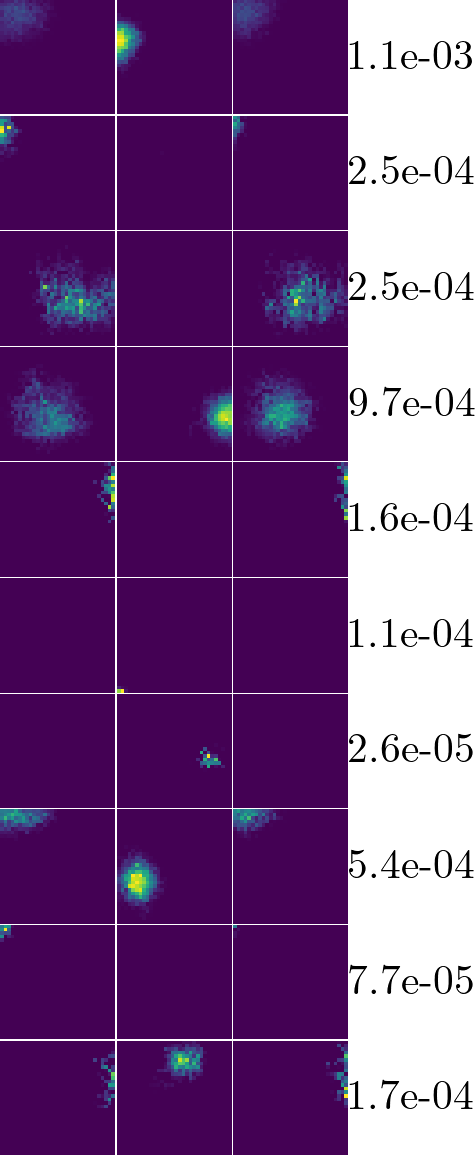

In [10]:
max_rates = np.nanmax(p_ratemaps, axis = (0,-2, -1))
tools.plot_sequence(p_ratemaps, show_units = 10, titles = max_rates,pane_size = 0.5, cmap= None, normalize = True);
plt.subplots_adjust(wspace = 0.01, hspace = 0.01)
# plt.savefig(f"./figures/{model_name}_global_remapping")

64

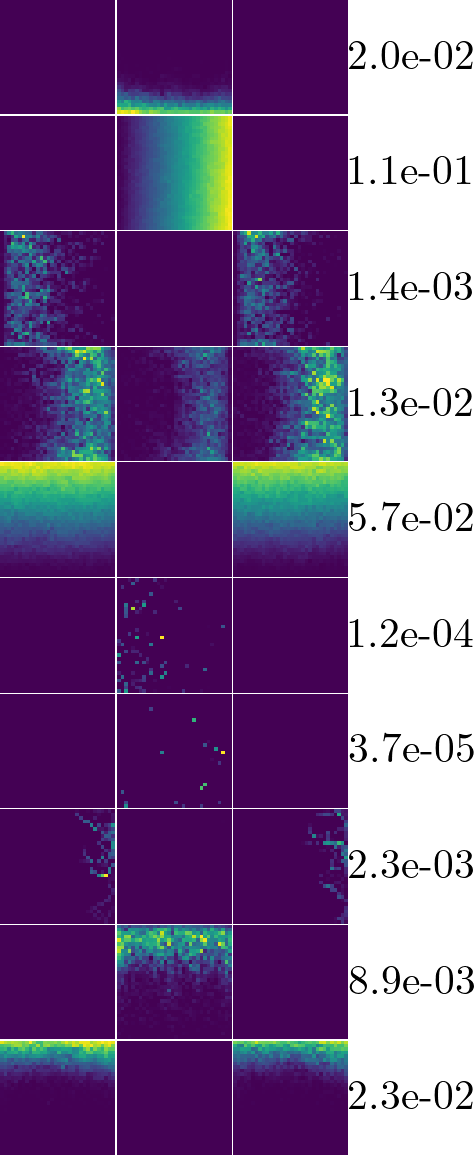

In [11]:
mask = np.sum(g_ratemaps, axis = (0, -2, -1)) > 1e-4
max_rates = np.nanmax(g_ratemaps, axis = (0,-2, -1))

select_g = g_ratemaps[:, mask]
tools.plot_sequence(select_g, show_units = 10, titles = max_rates[mask], pane_size = 0.5, normalize = True);

plt.subplots_adjust(wspace = 0.01, hspace = 0.01)
# plt.savefig(f"./figures/{model_name}_global_remapping_rnn")
mask.sum()

Now we can prepare to correlate the two environments. However, we need to filter out cells that are active from those that are not.

In [12]:
mask = np.amin(np.amax(p_ratemaps, axis = (-2, -1)), axis = 0) > 0

In [13]:
print("No. accepted cells:", np.sum(mask))

No. accepted cells: 60


In [14]:
accepted_maps = p_ratemaps[:, mask]
accepted_maps.shape

k = 10
most_active = np.argsort(np.amin(np.sum(accepted_maps, axis = (-2, -1)), axis = 0), axis = -1)[::-1][:k]

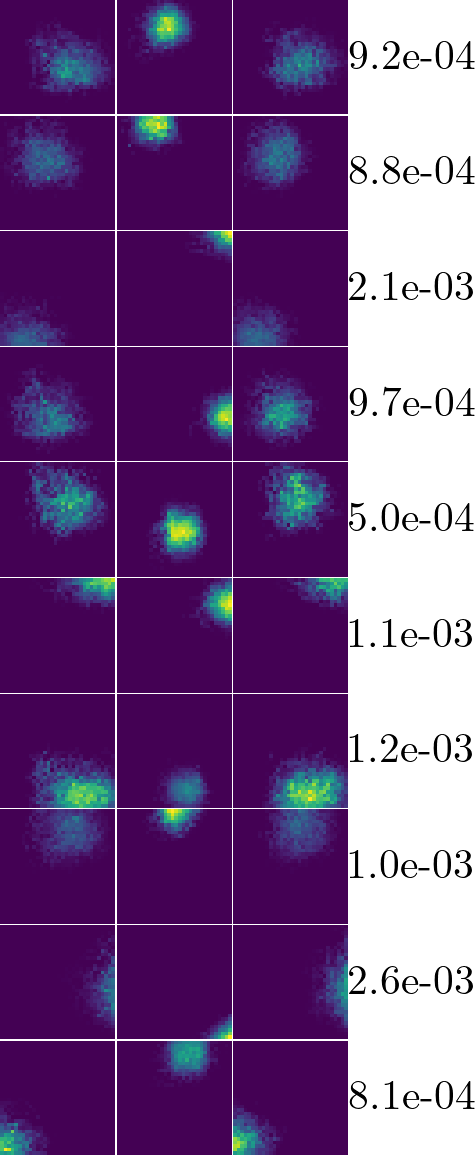

In [15]:
max_rates = np.amax(accepted_maps[:,most_active], axis = (0, -2, -1))
tools.plot_sequence(accepted_maps[:,most_active], show_units = k, titles = max_rates, pane_size = 0.5, normalize = True);
plt.subplots_adjust(wspace = 0.01, hspace = 0.01)
plt.savefig(f"./figures/{model_name}_global_remapping_high_spatial_information")

### Statistics

In [16]:
# correlate initial environment with all others for possible rotations
orientations = np.array([90*i for i in range(4)]) # Degrees 🔪
corrs = np.zeros((len(sequence),len(orientations), accepted_maps.shape[1], accepted_maps.shape[1]))

for i in range(len(sequence)):
    # do correlation
    for j in range(len(orientations)):
        rotated_ratemaps = scipy.ndimage.rotate(accepted_maps[i], orientations[j], axes = (1, 2))
        # Pearson correlation between ratemaps of single cells
        corrs[i,j] = stats.correlate_population_vectors_unitwise(accepted_maps[0], rotated_ratemaps)

In [17]:
self_correlation = np.diagonal(corrs, axis1 = 2, axis2 = 3) 
median_self_correlation = np.median(self_correlation, axis = -1)
angle_inds = np.argmax(median_self_correlation, axis = 1)
maximal_angle = orientations[angle_inds]

# only keep angle that maximises median correlation
self_correlation = self_correlation[np.arange(len(sequence)), angle_inds]
median_self_correlation = median_self_correlation[np.arange(len(sequence)), angle_inds]
mean_self_correlation = np.mean(self_correlation, axis = -1)
corrs = corrs[np.arange(len(sequence)), angle_inds]

print(f"Maximal median correlation angles: {maximal_angle}", self_correlation.shape)

Maximal median correlation angles: [0 0 0] (3, 60)


### Cell-to-cell ratemap correlation

In [18]:
# Only the upper triangular contributes to the test result
triu_mask = np.ravel(np.triu(np.ones(corrs.shape[1:],dtype="bool"), k = 1)) 

# and flatten to mask out correct entries
flat_dist = np.reshape(corrs, (len(sequence), -1))
shuffled_distribution = flat_dist[:,triu_mask]

median_correlations = np.median(np.amax(self_correlation, axis = 1), axis = -1)
ci_95 = np.percentile(shuffled_distribution, 95.0, axis = -1) 

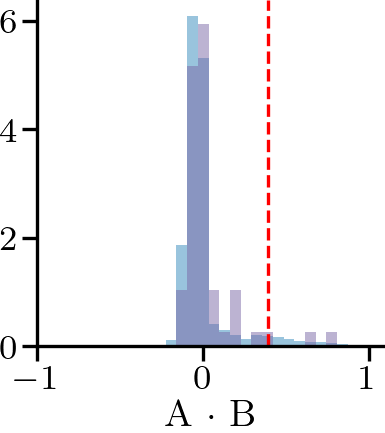

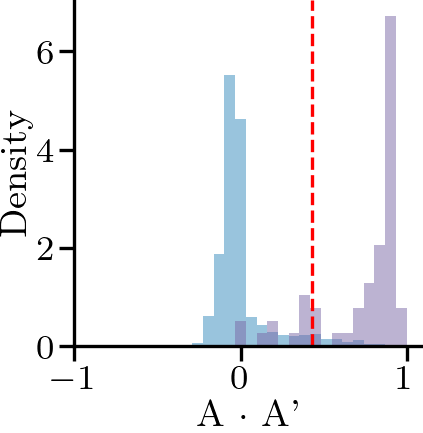

In [25]:
corr_symbol = '$\cdot$' 
seq_labels = ["A", "B", "A'"]

# plot distributions
lim = 0

hist_bins = np.linspace(-0.25, 1, 32)
for i in range(1, len(sequence)):
    plt.figure()
    if i == 2:
        plt.ylabel("Density")

    b = plt.hist(shuffled_distribution[i], alpha = 0.5, density = True, bins = hist_bins)
    a = plt.hist(self_correlation[i], alpha = 0.5, density = True, bins = hist_bins)
    plt.xlabel(f"{seq_labels[0]} {corr_symbol} {seq_labels[i]}")
    new_lim = np.maximum(np.amax(a[0]), np.amax(b[0]))*1.05
    if new_lim > lim:
        lim = new_lim
    plt.vlines(ci_95[i], 0, lim, color = "r", linestyles= "dashed")
    plt.axis([-1, 1.1, 0, lim])
    # plt.savefig(f"./figures/{model_name}_global_remapping_spatial_correlation_{i}")

In [20]:
above_95ci = np.sum(self_correlation > ci_95[:,None], axis = -1)#/self_correlation.shape[-1]
above_95ci[1:], above_95ci[1:]/self_correlation.shape[-1] # (array([ 3, 53]), array([0.04761905, 0.84126984]))

(array([ 3, 49]), array([0.05      , 0.81666667]))

### Rate overlap

In [21]:
overlap = []
random_overlap = []

for i in range(len(sequence)):
    active = ((np.amax(p_ratemaps[0], axis = (-2, -1)) > 0) + (np.amax(p_ratemaps[i], (-2, -1)) > 0)).astype(bool)
    overlap.append(stats.rate_overlap(p_ratemaps[0,active], p_ratemaps[i,active]))

    shuffled_overlap = stats.random_rate_overlap(p_ratemaps[0,active], p_ratemaps[i,active])    
    random_overlap.append(shuffled_overlap[~np.isnan(shuffled_overlap)]) # exclude comparisons where both ratemaps are inactive

/home/m/Documents/phd/VPC/notebooks/stats.py:99: RuntimeWarning: invalid value encountered in true_divide
  rate_overlap = smallest/largest


/tmp/ipykernel_68010/106182788.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  b = plt.hist(overlap[j], alpha = 0.65, density = True, bins = hist_bins, color = matplotlib.cm.get_cmap("Oranges")(0.3))


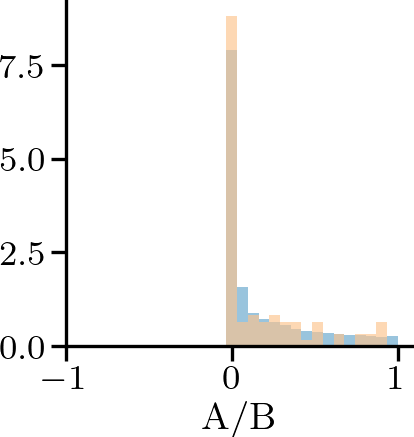

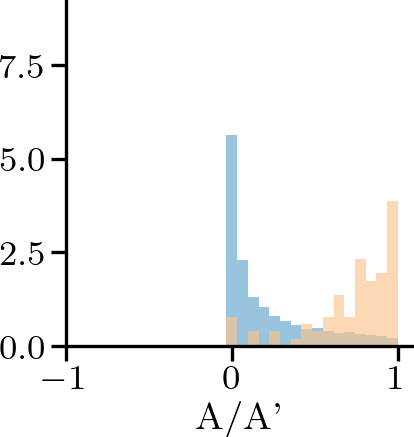

In [26]:
labels = []
symbol = "/"

lim = 0
for j in range(1, len(sequence)):
    plt.figure()
    a = plt.hist(random_overlap[j], alpha =0.5, density = True, bins = hist_bins)
    b = plt.hist(overlap[j], alpha = 0.65, density = True, bins = hist_bins, color = matplotlib.cm.get_cmap("Oranges")(0.3))

    new_lim = np.maximum(np.amax(a[0]), np.amax(b[0]))*1.05
    if new_lim > lim:
        lim = new_lim
    plt.axis([-1, 1.1, 0, lim])
    plt.xlabel(f"{seq_labels[0]}{symbol}{seq_labels[j]}")
    # plt.savefig(f"./figures/{model_name}_rate_overlap_div_{j}")

In [23]:
difference = []
random_difference = []
for i in range(len(sequence)):
    active = ((np.amax(p_ratemaps[0], axis = (-2, -1)) > 0) + (np.amax(p_ratemaps[i], (-2, -1)) > 0)).astype(bool)
    difference.append(stats.rate_difference(p_ratemaps[0,active], p_ratemaps[i,active]))
    random_difference.append(stats.random_rate_difference(p_ratemaps[0,active], p_ratemaps[i,active]))

/home/m/Documents/phd/VPC/notebooks/stats.py:116: RuntimeWarning: invalid value encountered in true_divide
  rate_diff = (sum_a - sum_b)/(sum_a + sum_b)


/tmp/ipykernel_68010/2356613923.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  a = plt.hist(difference[j], alpha = 0.5, density = True, bins = hist_bins, color = matplotlib.cm.get_cmap("Reds")(0.6))


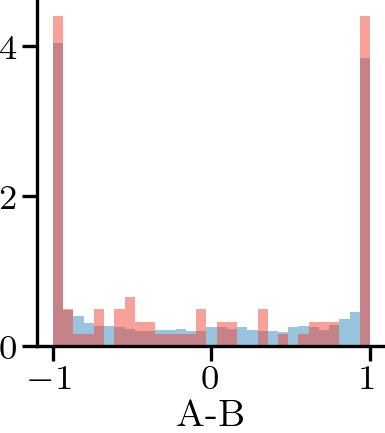

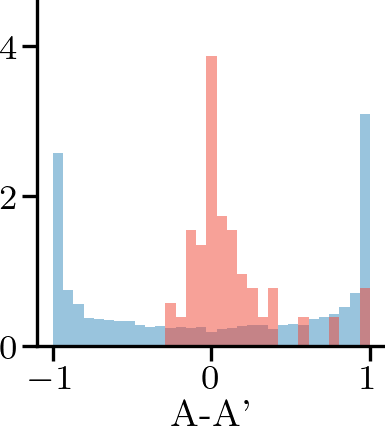

In [31]:
labels = []
symbol = "-"
lim = 0
hist_bins = np.linspace(-1, 1, 32)

for j in range(1, len(sequence)):
    plt.figure()
    b = plt.hist(random_difference[j].ravel(), alpha = 0.5, density = True, bins = hist_bins)
    a = plt.hist(difference[j], alpha = 0.5, density = True, bins = hist_bins, color = matplotlib.cm.get_cmap("Reds")(0.6))
    new_lim = np.maximum(np.amax(a[0]), np.amax(b[0]))*1.05
    if new_lim > lim:
        lim = new_lim
    plt.axis([-1.1, 1.1, 0, lim])
    plt.xlabel(f"{seq_labels[0]}{symbol}{seq_labels[j]}")
    # plt.savefig(f"./figures/{model_name}_rate_overlap_diff_{j}")